In [4]:
import pandas as pd
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns',None)
pd.options.display.max_seq_items = 2000
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import requests, re
import pandas as pd
import seaborn as sns
import nltk
import string, itertools
from collections import Counter, defaultdict
from nltk.text import Text
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from sklearn.cluster import KMeans
from wordcloud import WordCloud

In [7]:
#url='https://www.kaggle.com/yelp-dataset/yelp-dataset/version/6'
business = pd.read_csv('/kaggle/input/yelp-dataset/yelp_business.csv')
business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,"""Western Motor Vehicle""",NaN,"""6025 N 27th Ave, Ste 1""",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,"""Sports Authority""",NaN,"""5000 Arizona Mills Cr, Ste 435""",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,"""Brick House Tavern + Tap""",NaN,"""581 Howe Ave""",Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [8]:
## drop unuseful column 'neighborhood' 
business.drop(['neighborhood'], axis=1, inplace=True)

## remove quotation marks in name and address column
business.name=business.name.str.replace('"','')
business.address=business.address.str.replace('"','')

## filter restaurants of US
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
usa=business.loc[business['state'].isin(states)]
business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,Dental by Design,"4855 E Warner Rd, Ste B9",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,Stephen Szabo Salon,3101 Washington Rd,McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...
2,KQPW8lFf1y5BT2MxiSZ3QA,Western Motor Vehicle,"6025 N 27th Ave, Ste 1",Phoenix,AZ,85017,33.524903,-112.115310,1.5,18,1,Departments of Motor Vehicles;Public Services ...
3,8DShNS-LuFqpEWIp0HxijA,Sports Authority,"5000 Arizona Mills Cr, Ste 435",Tempe,AZ,85282,33.383147,-111.964725,3.0,9,0,Sporting Goods;Shopping
4,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American (New);Nightlife;Bars;Sandwiches;Ameri...


In [9]:
## select all restaurants in USA
us_restaurants=usa[usa['categories'].str.contains('Restaurants')]

## select out 16 cuisine types of restaurants and rename the category
us_restaurants.is_copy=False
us_restaurants['category']=pd.Series()
us_restaurants.loc[us_restaurants.categories.str.contains('American'),'category'] = 'American'
us_restaurants.loc[us_restaurants.categories.str.contains('Mexican'), 'category'] = 'Mexican'
us_restaurants.loc[us_restaurants.categories.str.contains('Italian'), 'category'] = 'Italian'
us_restaurants.loc[us_restaurants.categories.str.contains('Japanese'), 'category'] = 'Japanese'
us_restaurants.loc[us_restaurants.categories.str.contains('Chinese'), 'category'] = 'Chinese'
us_restaurants.loc[us_restaurants.categories.str.contains('Thai'), 'category'] = 'Thai'
us_restaurants.loc[us_restaurants.categories.str.contains('Mediterranean'), 'category'] = 'Mediterranean'
us_restaurants.loc[us_restaurants.categories.str.contains('French'), 'category'] = 'French'
us_restaurants.loc[us_restaurants.categories.str.contains('Vietnamese'), 'category'] = 'Vietnamese'
us_restaurants.loc[us_restaurants.categories.str.contains('Greek'),'category'] = 'Greek'
us_restaurants.loc[us_restaurants.categories.str.contains('Indian'),'category'] = 'Indian'
us_restaurants.loc[us_restaurants.categories.str.contains('Korean'),'category'] = 'Korean'
us_restaurants.loc[us_restaurants.categories.str.contains('Hawaiian'),'category'] = 'Hawaiian'
us_restaurants.loc[us_restaurants.categories.str.contains('African'),'category'] = 'African'
us_restaurants.loc[us_restaurants.categories.str.contains('Spanish'),'category'] = 'Spanish'
us_restaurants.loc[us_restaurants.categories.str.contains('Middle_eastern'),'category'] = 'Middle_eastern'
us_restaurants.category[:20]

/tmp/ipykernel_47/4256751099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_restaurants['category']=pd.Series()


4     American
10         NaN
14    American
28         NaN
29    American
40    Japanese
44     Italian
45         NaN
46         NaN
52    American
53         NaN
54    American
64         NaN
72         NaN
75         NaN
76         NaN
80         NaN
81    American
88         NaN
91     Italian
Name: category, dtype: object

In [10]:
## drop null values in category, delete original column categories and reset the index
us_restaurants=us_restaurants.dropna(axis=0, subset=['category'])
del us_restaurants['categories']
us_restaurants=us_restaurants.reset_index(drop=True)
us_restaurants.head(10)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,category
0,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.475690,3.5,116,1,American
1,fNMVV_ZX7CJSDWQGdOM8Nw,Showmars Government Center,600 E 4th St,Charlotte,NC,28202,35.221647,-80.839345,3.5,7,1,American
2,gAy4LYpsScrj8POnCW6btQ,Toast Cafe,2429 Hwy 160 W,Fort Mill,SC,29708,35.047287,-80.990559,3.5,6,0,American
3,tRVx2c89coruPRwYhGTcTw,Yuzu,13603 Madison Ave,Lakewood,OH,44107,41.476846,-81.786971,3.5,78,1,Japanese
4,BnuzcebyB1AfxH0kjNWqSg,Carrabba's Italian Grill,245 Lancaster Ave,Frazer,PA,19355,40.041003,-75.542497,3.5,25,0,Italian
5,Pd52CjgyEU3Rb8co6QfTPw,Flight Deck Bar & Grill,6730 S Las Vegas Blvd,Las Vegas,NV,89119,36.066914,-115.170848,4.0,13,1,American
6,n7V4cD-KqqE3OXk0irJTyA,GameWorks,"6587 Las Vegas Blvd S, Ste 171",Las Vegas,NV,89119,36.068259,-115.178877,3.0,349,1,American
7,B5EZlEDH6AVDk8tQGHAGqg,Villa Tap,2302 Packers Ave,Madison,WI,53704,43.123389,-89.355390,4.0,34,1,American
8,F0fEKpTk7gAmuSFI0KW1eQ,Cafe Mastrioni,"4250 S Rainbow Blvd, Ste 1007",Las Vegas,NV,89103,36.111057,-115.241688,1.5,3,0,Italian
9,VdlPZg2NAu8t8GkdbPLecg,Tandoori Times Indian Bistro,"8140 N Hayden Rd, Ste H115",Scottsdale,AZ,85258,33.555212,-111.900456,3.5,263,1,Indian


In [11]:
## check total number of us restaurants
us_restaurants.shape

(19156, 12)

In [12]:
## check whether has duplicated business id
us_restaurants.business_id.duplicated().sum()

0

In [13]:
## check the datatype
us_restaurants.dtypes

business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
category         object
dtype: object

In [14]:
## check missing values
us_restaurants.isnull().sum()

business_id      0
name             0
address          0
city             0
state            0
postal_code     22
latitude         0
longitude        0
stars            0
review_count     0
is_open          0
category         0
dtype: int64

In [15]:
## load review table
review = pd.read_csv('/kaggle/input/yelp-dataset/yelp_review.csv')
review.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [16]:
## check missing values
review.isnull().sum()

review_id      0
user_id        0
business_id    0
stars          0
date           0
text           0
useful         0
funny          0
cool           0
dtype: int64

In [17]:
## check duplicates of review_id
review.review_id.duplicated().sum()

0

In [18]:
## merge business table and review table
restaurants_reviews = pd.merge(us_restaurants, review, on = 'business_id')

## update column names
restaurants_reviews.rename(columns={'stars_x':'avg_star','stars_y':'review_star'}, inplace=True)

## add column of number of words in review and label of negative and postive reviews
restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))
    

In [19]:
## add column of number of words in review and label of negative and postive reviews
restaurants_reviews['num_words_review'] = restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','').map(lambda x: len(x.split()))

In [20]:
# label reviews as positive or negative
restaurants_reviews['labels'] = ''
restaurants_reviews.loc[restaurants_reviews.review_star >=4, 'labels'] = 'positive'
restaurants_reviews.loc[restaurants_reviews.review_star ==3, 'labels'] = 'neural'
restaurants_reviews.loc[restaurants_reviews.review_star <3, 'labels'] = 'negative'

# drop neutral reviews for easy analysis
restaurants_reviews.drop(restaurants_reviews[restaurants_reviews['labels'] =='neural'].index, axis=0, inplace=True)
restaurants_reviews.reset_index(drop=True, inplace=True)

restaurants_reviews.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,avg_star,review_count,is_open,category,review_id,user_id,review_star,date,text,useful,funny,cool,num_words_review,labels
0,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.47569,3.5,116,1,American,rnvu74aNIPn93Z9Ue11Epw,bgtr7jOlALe8ay4g7pnf4A,4,2016-05-05,I've always enjoyed my time at brick house foo...,0,0,0,37,positive
1,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.47569,3.5,116,1,American,OE5dH664oSSK_-TvIl263w,ndZOHkG_FWdL4TRd9xRfNQ,2,2017-03-19,1st time here. Came w my Unc bc Louies was clo...,0,0,0,60,negative
2,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.47569,3.5,116,1,American,SWeHmo8uHHWbbv94VdAMeQ,UqtE83J-6NMQNNJzpnWwEQ,1,2015-08-31,Worse service ever andI use to be a server so ...,0,0,0,106,negative
3,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.47569,3.5,116,1,American,fCCL0pAgYGccUs8shHHIUA,PixAmdRa58XZ3hr8YLS36g,5,2015-10-09,I am updating my review to 5-stars because I t...,2,0,2,501,positive
4,PfOCPjBrlQAnz__NXj9h_w,Brick House Tavern + Tap,581 Howe Ave,Cuyahoga Falls,OH,44221,41.119535,-81.47569,3.5,116,1,American,-VOh0NNnIo1r24hjwSZL4Q,Hly0NEWXMxbuXa2zm_NJOQ,4,2015-01-15,I enjoyed this place. I went the night the Bu...,0,0,0,58,positive


In [23]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

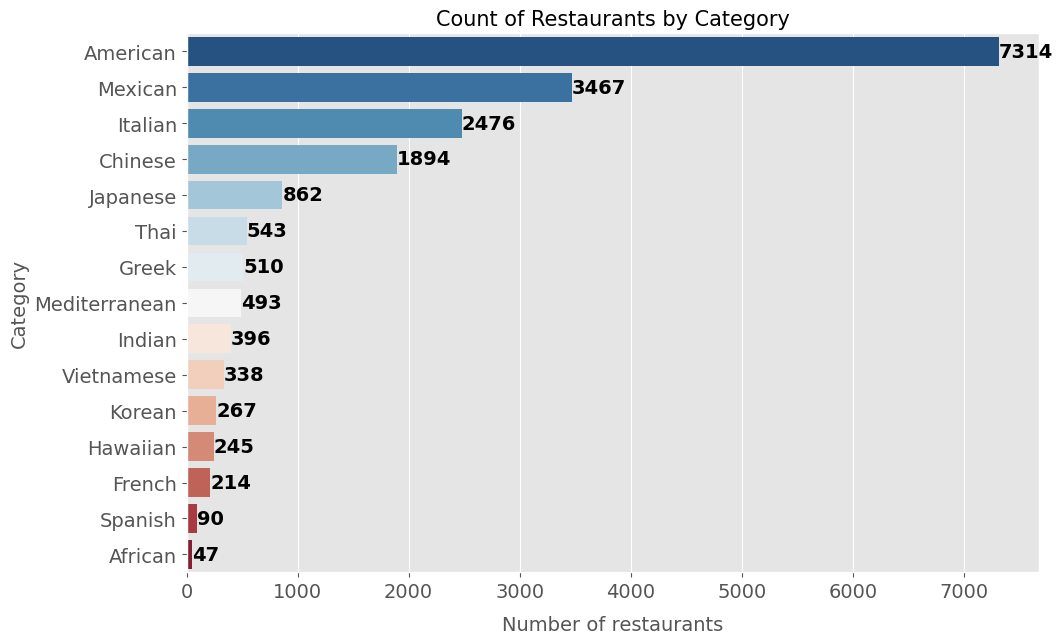

In [24]:
plt.figure(figsize=(11,7))
grouped = us_restaurants.category.value_counts()
sns.countplot(y='category',data=us_restaurants, 
              order = grouped.index, palette= sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Number of restaurants', fontsize=14, labelpad=10)
plt.ylabel('Category', fontsize=14)
plt.title('Count of Restaurants by Category', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(us_restaurants.category.value_counts()):
    plt.text(v, i+0.15, str(v), fontweight='bold', fontsize=14)

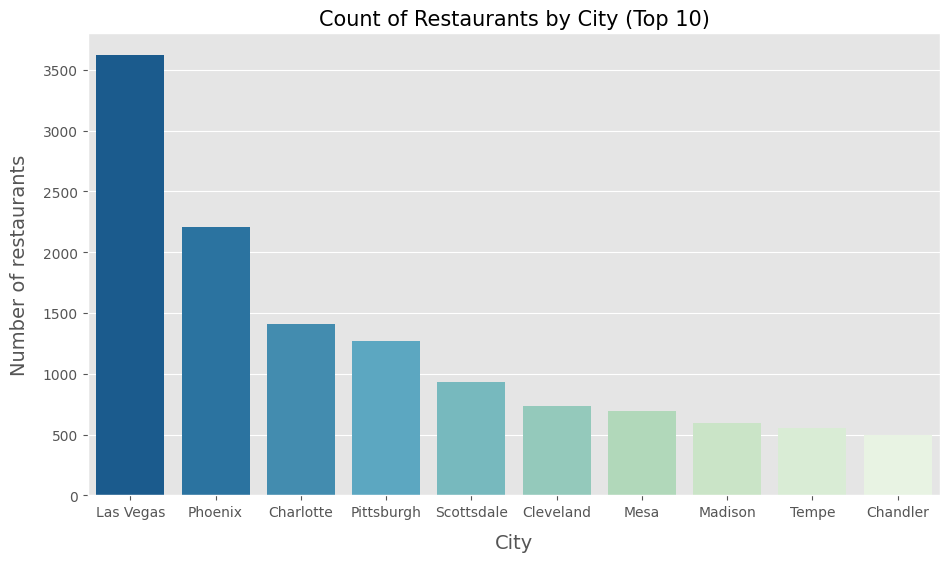

In [28]:
'''plt.figure(figsize=(11,6))
grouped = us_restaurants.city.value_counts()[:10]
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)))
plt.ylabel('Number of restaurants', fontsize=14, labelpad=10)
plt.xlabel('City', fontsize=14, labelpad=10)
plt.title('Count of Restaurants by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)'''
plt.figure(figsize=(11,6))
grouped = us_restaurants.city.value_counts()[:10]
sns.barplot(x=grouped.index, y=grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)))
plt.ylabel('Number of restaurants', fontsize=14, labelpad=10)
plt.xlabel('City', fontsize=14, labelpad=10)
plt.title('Count of Restaurants by City (Top 10)', fontsize=15)
plt.show()


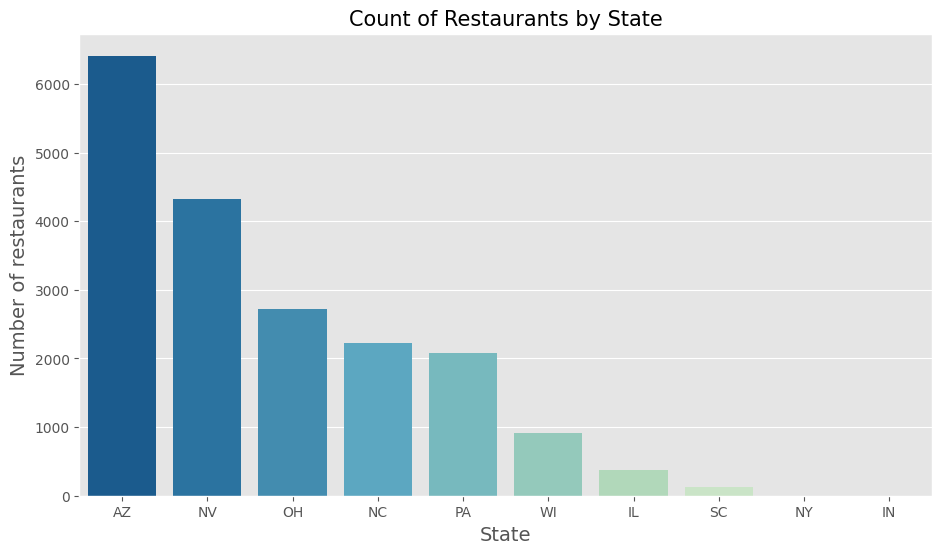

In [30]:
'''plt.figure(figsize=(11,6))
grouped = us_restaurants.state.value_counts()
sns.barplot(grouped.index, grouped.values,palette=sns.color_palette("GnBu_r", len(grouped)) )
plt.ylabel('Number of restaurants', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.title('Count of Restaurants by State', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center', fontweight='bold', fontsize=14)'''
plt.figure(figsize=(11, 6))
grouped = us_restaurants.state.value_counts()
sns.barplot(x=grouped.index, y=grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)))
plt.ylabel('Number of restaurants', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.title('Count of Restaurants by State', fontsize=15)
plt.show()


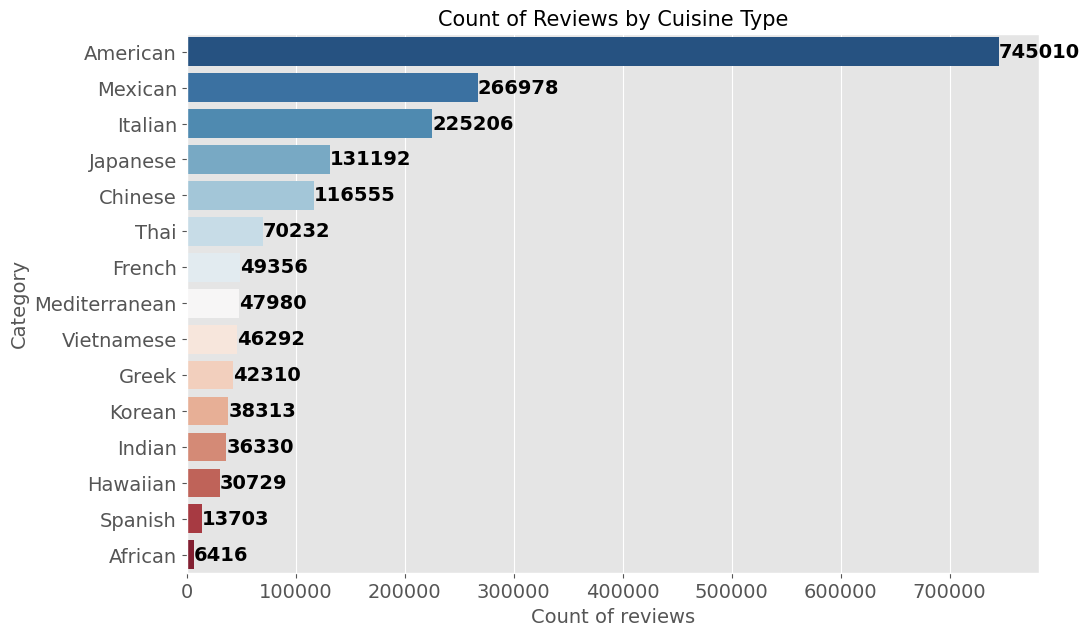

In [31]:
plt.figure(figsize=(11,7))
grouped = us_restaurants.groupby('category')['review_count'].sum().sort_values(ascending = False)
sns.barplot(y=grouped.index, x= grouped.values, palette= sns.color_palette("RdBu_r", len(grouped)) )
plt.ylabel('Category', fontsize=14)
plt.xlabel('Count of reviews', fontsize=14)
plt.title('Count of Reviews by Cuisine Type', fontsize=15)
for i,v in enumerate(grouped):
    plt.text(v, i+0.15, str(v),fontweight='bold', fontsize=14)
plt.tick_params(labelsize=14)

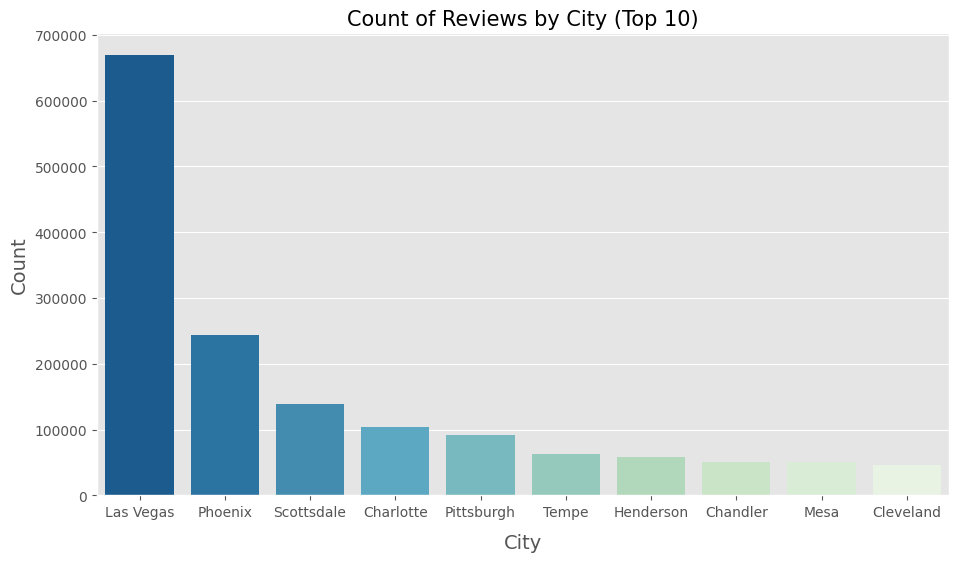

In [33]:
    
plt.figure(figsize=(11, 6))
grouped = us_restaurants.groupby('city')['review_count'].sum().sort_values(ascending=False)[:10]
sns.barplot(x=grouped.index, y=grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)))
plt.xlabel('City', labelpad=10, fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Reviews by City (Top 10)', fontsize=15)
plt.show()


/tmp/ipykernel_47/3878891014.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=grouped.review_count, y = grouped.name, palette=sns.color_palette("GnBu_r", len(grouped)), ci=None)


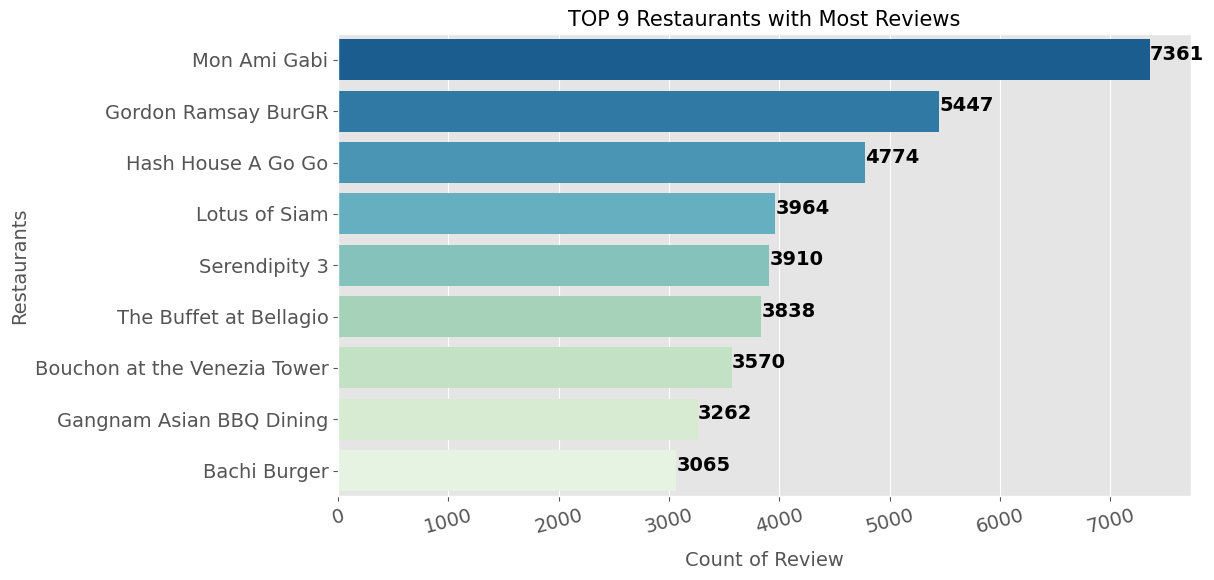

In [34]:
plt.figure(figsize=(11,6))
grouped = us_restaurants[['name','review_count']].sort_values(by='review_count', ascending=False)[:9]
sns.barplot(x=grouped.review_count, y = grouped.name, palette=sns.color_palette("GnBu_r", len(grouped)), ci=None)
plt.xlabel('Count of Review', labelpad=10, fontsize=14)
plt.ylabel('Restaurants', fontsize=14)
plt.title('TOP 9 Restaurants with Most Reviews', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped.review_count):
    plt.text(v, i, str(v), fontweight='bold', fontsize=14)

In [35]:
table = pd.pivot_table(restaurants_reviews, values=["review_id"], index=["category"],columns=["labels"], 
                       aggfunc=len, margins=True, dropna=True,fill_value=0)
table_percentage = table.div( table.iloc[:,-1], axis=0).iloc[:-1,-2].sort_values(ascending=False)

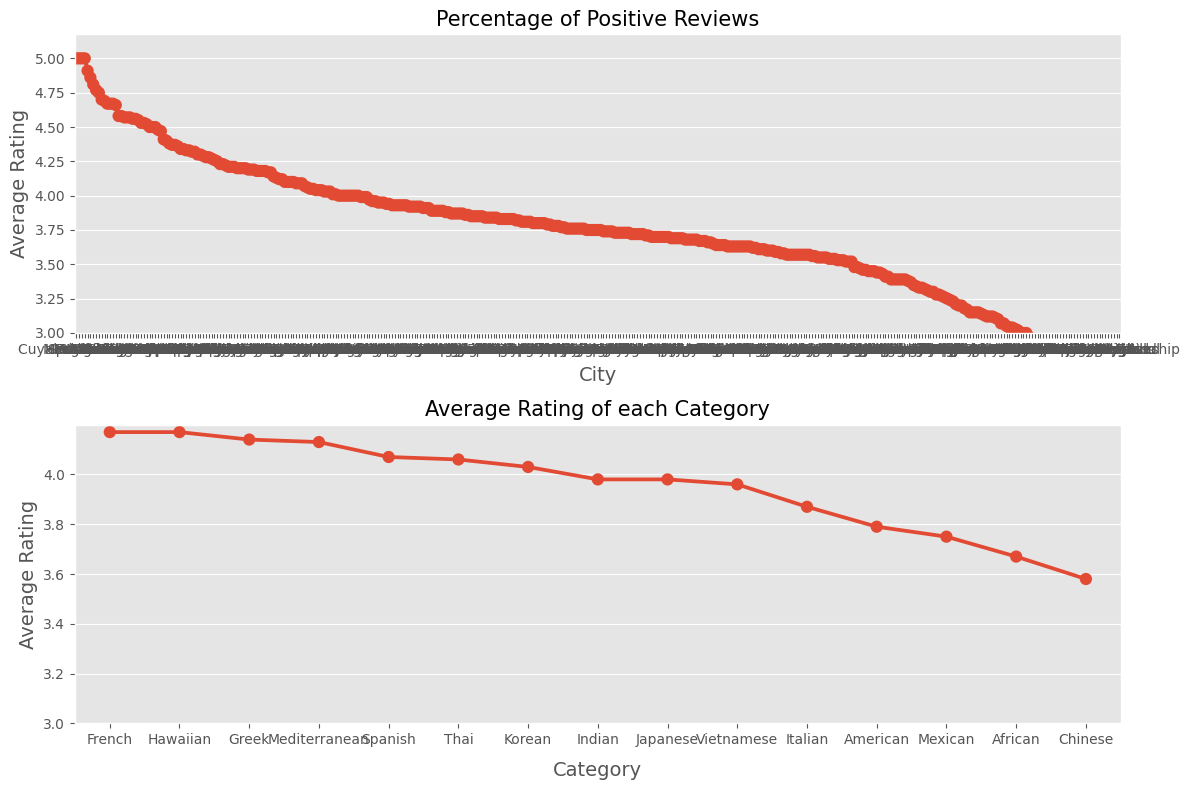

In [39]:
'''table = pd.pivot_table(restaurants_reviews, values=["review_id"], index=["category"],columns=["labels"], 
                       aggfunc=len, margins=True, dropna=True,fill_value=0)
table_percentage = table.div( table.iloc[:,-1], axis=0).iloc[:-1,-2].sort_values(ascending=False)
plt.figure(figsize=(11,8))
plt.subplot(211)
sns.pointplot(x=table_percentage.index, y= table_percentage.values)
plt.xlabel('Category', labelpad=7, fontsize=14)
plt.ylabel('Percentage of positive reviews', fontsize=14)
plt.title('Percentage of Positive Reviews', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=40)
for  i, v in enumerate(table_percentage.round(2)):
    plt.text(i, v*1.001, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    
plt.subplot(212)
grouped = restaurants_reviews.groupby('category')['review_star'].mean().round(2).sort_values(ascending=False)
sns.pointplot(grouped.index, grouped.values)
plt.ylim(3)
plt.xlabel('Catagory', labelpad=10, fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.title('Average Rating of each Category', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=40)
for  i, v in enumerate(grouped):
    plt.text(i, v, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
    
plt.subplots_adjust(hspace=1)'''
plt.figure(figsize=(12, 8))

# First subplot
plt.subplot(211)
grouped_city = restaurants_reviews.groupby('city')['review_star'].mean().round(2).sort_values(ascending=False)
sns.pointplot(x=grouped_city.index, y=grouped_city.values)
plt.ylim(3)
plt.xlabel('City', labelpad=7, fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.title('Percentage of Positive Reviews', fontsize=15)

# Second subplot
plt.subplot(212)
grouped_category = restaurants_reviews.groupby('category')['review_star'].mean().round(2).sort_values(ascending=False)
sns.pointplot(x=grouped_category.index, y=grouped_category.values)
plt.ylim(3)
plt.xlabel('Category', labelpad=10, fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.title('Average Rating of each Category', fontsize=15)

plt.tight_layout()
plt.show()


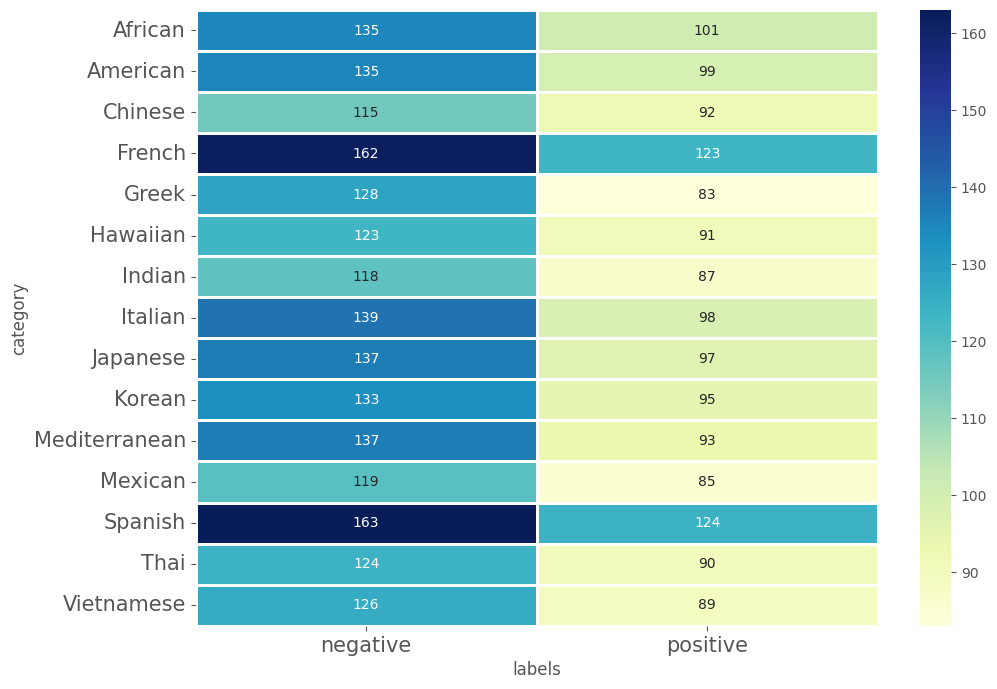

In [40]:
table = restaurants_reviews.groupby(['category','labels'])['num_words_review'].mean().round().unstack()
plt.figure(figsize=(11,8))
sns.heatmap(table, cmap='YlGnBu', fmt='g',annot=True, linewidths=1)
plt.tick_params(labelsize=15)

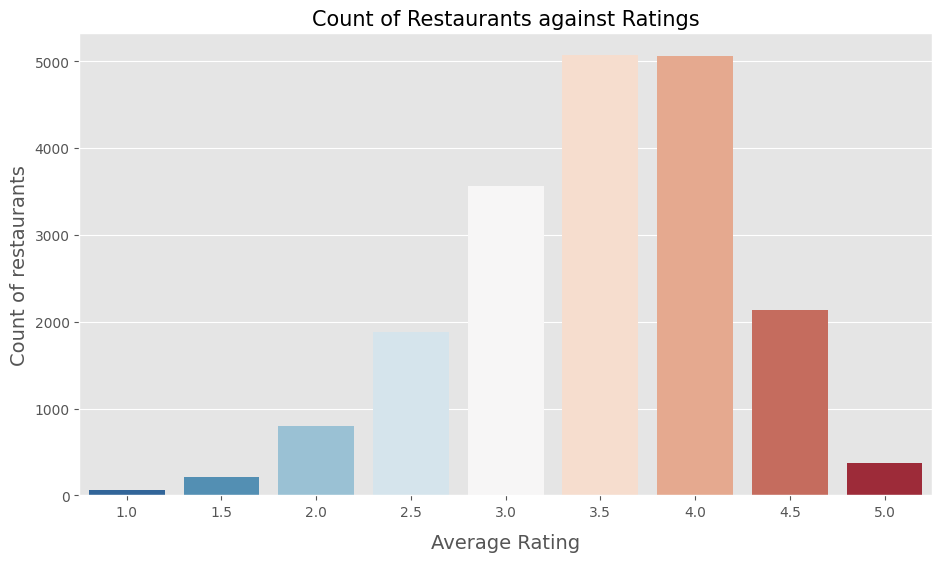

In [42]:

plt.figure(figsize=(11, 6))
grouped = us_restaurants.stars.value_counts().sort_index()
sns.barplot(x=grouped.index, y=grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Average Rating', labelpad=10, fontsize=14)
plt.ylabel('Count of restaurants', fontsize=14)
plt.title('Count of Restaurants against Ratings', fontsize=15)
plt.show()


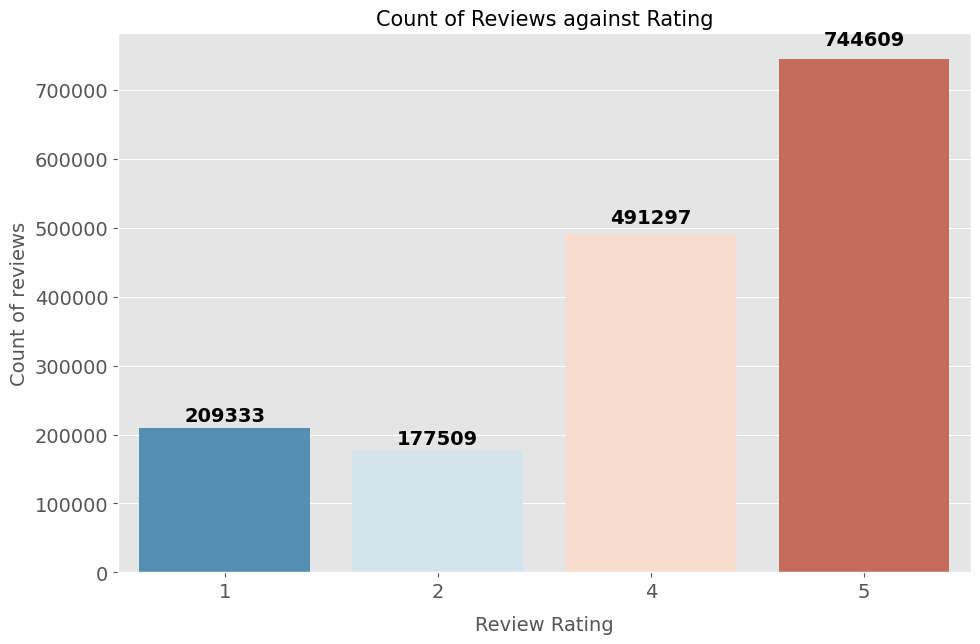

In [44]:
plt.figure(figsize=(11, 7))
grouped = restaurants_reviews['review_star'].value_counts().sort_index()
sns.barplot(x=grouped.index, y=grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Review Rating', labelpad=10, fontsize=14)
plt.ylabel('Count of reviews', fontsize=14)
plt.title('Count of Reviews against Rating', fontsize=15)
plt.tick_params(labelsize=14)

for i, v in enumerate(grouped):
    plt.text(i, v * 1.02, str(v), ha='center', va='bottom', fontweight='bold', fontsize=14)

plt.show()

Review

In [46]:
import csv
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [47]:
## convert text to lower case
restaurants_reviews.text = restaurants_reviews.text.str.lower()

## remove unnecessary punctuation
restaurants_reviews['removed_punct_text']= restaurants_reviews.text.str.replace('\n',''). \
                                          str.replace('[!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~]','')

In [50]:
## import positive file which contains common meaningless positive words such as good
file_positive = open('/kaggle/input/wordss/positive.txt')
reader =csv.reader(file_positive)
positive_words = [word[0] for word in reader]

## import negative file which contains common meaningless positive words such as bad
file_negative = open('/kaggle/input/wordss/negative.txt')
reader =csv.reader(file_negative)
negative_words = [word[0] for word in reader]

In [51]:
## get dataset by category
def get_dataset(category):
    df = restaurants_reviews[['removed_punct_text','labels']][restaurants_reviews.category==category]
    df.reset_index(drop=True, inplace =True)
    df.rename(columns={'removed_punct_text':'text'}, inplace=True)
    return df



## only keep positive and negative words
def filter_words(review):
    words = [word for word in review.split() if word in positive_words + negative_words]
    words = ' '.join(words)
    return words

In [52]:
Korean_reviews = get_dataset('Korean')

In [53]:
Korean_train, Korean_test = train_test_split(Korean_reviews[['text','labels']],test_size=0.5)


In [54]:
print('Total %d number of reviews' % Korean_train.shape[0])

Total 16796 number of reviews


In [55]:
def split_data(dataset, test_size):
    df_train, df_test = train_test_split(dataset[['text','labels']],test_size=test_size)
    return df_train

In [56]:
## filter words
Korean_train.text = Korean_train.text.apply(filter_words)

In [58]:
## construct features and labels
terms_train=list(Korean_train['text'])
class_train=list(Korean_train['labels'])

terms_test=list(Korean_test['text'])
class_test=list(Korean_test['labels'])


In [59]:
## get bag of words : the frequencies of various words appeared in each review
vectorizer = CountVectorizer()
feature_train_counts=vectorizer.fit_transform(terms_train)
feature_train_counts.shape


(16796, 2504)

In [64]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer

# Assuming feature_train_counts and class_train are defined elsewhere in your code

# Create an instance of LinearSVC
svm = LinearSVC(max_iter=10000)

# Fit the model to your training data
svm.fit(feature_train_counts, class_train)

LinearSVC(max_iter=10000)

In [67]:
# Get the coefficients and feature names
coeff = svm.coef_[0]
feature_names = vectorizer.get_feature_names_out()

# Create a DataFrame
Korean_words_score = pd.DataFrame({'score': coeff, 'word': feature_names})

# Sort the DataFrame by the absolute values of the scores
Korean_words_score['abs_score'] = Korean_words_score['score'].abs()
Korean_words_score = Korean_words_score.sort_values(by='abs_score', ascending=False)

# Drop the temporary column
Korean_words_score = Korean_words_score.drop(columns=['abs_score'])

# Display the DataFrame
print(Korean_words_score.head())

       score       word
1239 -2.0469  infuriate
1489 -1.9811    mundane
2112 -1.8464   stricken
993  -1.8264    gleeful
2083  1.8052     steady


In [70]:
# Create a DataFrame with word frequencies for all reviews
Korean_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names_out())
Korean_reviews['labels'] = class_train

# Select positive reviews and calculate word frequencies
Korean_frequency = Korean_reviews.loc[Korean_reviews['labels'] == 'positive'].sum()[:-1]

In [71]:
Korean_words_score.set_index('word', inplace=True)

In [72]:
Korean_polarity_score = Korean_words_score
Korean_polarity_score['frequency'] = Korean_frequency

In [73]:
## calculate polarity score 
Korean_polarity_score['polarity'] = Korean_polarity_score.score * Korean_polarity_score.frequency / Korean_reviews.shape[0]

In [74]:
## drop unnecessary words
unuseful_positive_words = Korean_polarity_score.loc[['great','amazing','love','best','awesome','excellent','good',
                                                    'favorite','loved','perfect','gem','perfectly','wonderful',
                                                    'happy','enjoyed','nice','well','super','like','better','decent','fine',
                                                    'pretty','enough','excited','impressed','ready','fantastic','glad','right',
                                                    'fabulous']]
unuseful_negative_words =  Korean_polarity_score.loc[['bad','disappointed','unfortunately','disappointing','horrible',
                                                     'lacking','terrible','sorry', 'disappoint']]

Korean_polarity_score.drop(unuseful_positive_words.index, axis=0, inplace=True)
Korean_polarity_score.drop(unuseful_negative_words.index, axis=0, inplace=True)

In [75]:
Korean_polarity_score.polarity = Korean_polarity_score.polarity.astype(float)
Korean_polarity_score.frequency = Korean_polarity_score.frequency.astype(float)

In [76]:
Korean_polarity_score[Korean_polarity_score.polarity>0].sort_values('polarity', ascending=False)[:20]

,score,frequency,polarity
word,,,
delicious,0.4982,1401.0000,0.0416
friendly,0.2391,1365.0000,0.0194
recommend,0.1654,1520.0000,0.0150
attentive,0.3831,481.0000,0.0110
solid,0.8344,155.0000,0.0077
liked,0.2592,491.0000,0.0076
hot,0.0896,1376.0000,0.0073
authentic,0.2011,601.0000,0.0072
reasonable,0.3937,306.0000,0.0072


In [77]:
Korean_top_positive_words = ['delicious','friendly','attentive','recommend','fresh','variety','reasonable','tender','clean','authentic']
Korean_top_negative_words = ['bland','slow','expensive','overpriced', 'cold', 'greasy','sweet','fatty','rude','dirty']
Korean_top_words = Korean_polarity_score.loc[Korean_top_positive_words+Korean_top_negative_words,'polarity']

(array([-0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05]),
 [Text(-0.01, 0, '−0.01'),
  Text(0.0, 0, '0.00'),
  Text(0.01, 0, '0.01'),
  Text(0.019999999999999997, 0, '0.02'),
  Text(0.03, 0, '0.03'),
  Text(0.04, 0, '0.04'),
  Text(0.049999999999999996, 0, '0.05')])

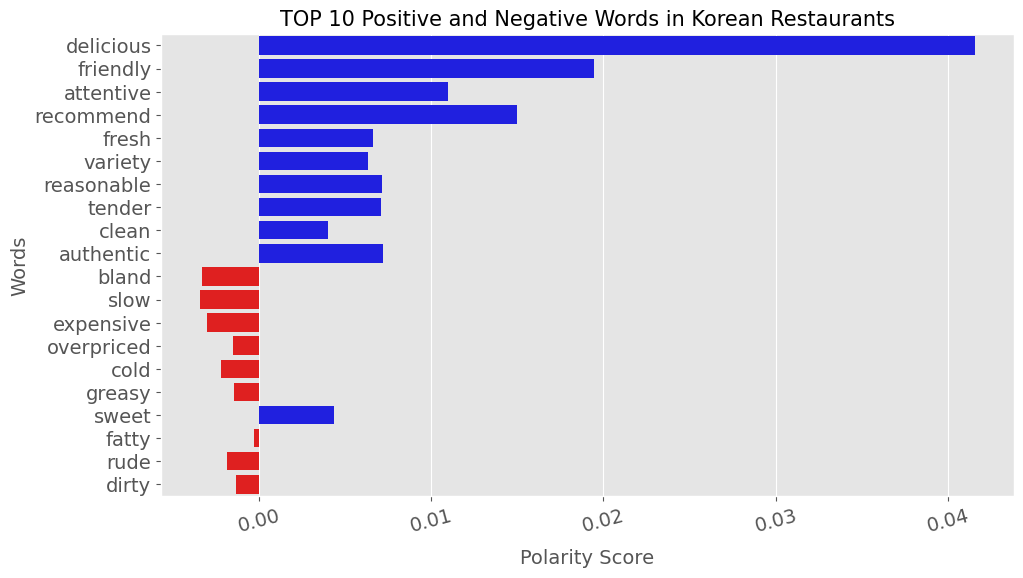

In [78]:
plt.figure(figsize=(11,6))
colors = ['red' if c < 0 else 'blue' for c in Korean_top_words.values]
sns.barplot(y=Korean_top_words.index, x=Korean_top_words.values, palette=colors)
plt.xlabel('Polarity Score', labelpad=10, fontsize=14)
plt.ylabel('Words', fontsize=14)
plt.title('TOP 10 Positive and Negative Words in Korean Restaurants', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)

In [92]:
def get_polarity_score(dataset):
    # Assuming filter_words is a function to process the text data
    dataset['text'] = dataset['text'].apply(filter_words)
    
    terms_train = list(dataset['text'])
    class_train = list(dataset['labels'])
    
    # Get bag of words
    vectorizer = CountVectorizer()
    feature_train_counts = vectorizer.fit_transform(terms_train)
    
    # Run the model
    svm = LinearSVC(max_iter=5000)
    svm.fit(feature_train_counts, class_train)
    
    # Create a DataFrame for the score of each word in a review calculated by the SVM model
    coeff = svm.coef_[0]
    cuisine_words_score = pd.DataFrame({'score': coeff, 'word': vectorizer.get_feature_names_out()})
    
    # Get the frequency of each word in all reviews in the specific category
    cuisine_reviews = pd.DataFrame(feature_train_counts.toarray(), columns=vectorizer.get_feature_names_out())
    cuisine_reviews['labels'] = class_train
    cuisine_frequency = cuisine_reviews[cuisine_reviews['labels'] == 'positive'].sum()[:-1]
    
    cuisine_words_score.set_index('word', inplace=True)
    cuisine_polarity_score = cuisine_words_score
    cuisine_polarity_score['frequency'] = cuisine_frequency
    
    cuisine_polarity_score['score'] = cuisine_polarity_score['score'].astype(float)
    cuisine_polarity_score['frequency'] = cuisine_polarity_score['frequency'].astype(int)
    
    # Calculate the polarity score 
    cuisine_polarity_score['polarity'] = (
        cuisine_polarity_score['score'] * cuisine_polarity_score['frequency'] / cuisine_reviews.shape[0]
    )
    
    cuisine_polarity_score['polarity'] = cuisine_polarity_score['polarity'].astype(float)
    
    # Drop unnecessary words
    unuseful_positive_words = ['great', 'amazing', 'love', 'best', 'awesome', 'excellent', 'good',
                               'favorite', 'loved', 'perfect', 'gem', 'perfectly', 'wonderful',
                               'happy', 'enjoyed', 'nice', 'well', 'super', 'like', 'better', 'decent', 'fine',
                               'pretty', 'enough', 'excited', 'impressed', 'ready', 'fantastic', 'glad', 'right',
                               'fabulous']
    unuseful_negative_words = ['bad', 'disappointed', 'unfortunately', 'disappointing', 'horrible',
                               'lacking', 'terrible', 'sorry']
    unuseful_words = unuseful_positive_words + unuseful_negative_words
    cuisine_polarity_score.drop(cuisine_polarity_score.loc[unuseful_words].index, axis=0, inplace=True)
    
    return cuisine_polarity_score


In [80]:
def plot_top_words(top_words, category):
    plt.figure(figsize=(11,6))
    colors = ['red' if c < 0 else 'blue' for c in top_words.values]
    sns.barplot(y=top_words.index, x=top_words.values, palette=colors)
    plt.xlabel('Polarity Score', labelpad=10, fontsize=14)
    plt.ylabel('Words', fontsize=14)
    plt.title('TOP 10 Positive and Negative Words in %s Restaurants ' % category, fontsize=15)
    plt.tick_params(labelsize=14)
    plt.xticks(rotation=15)

In [81]:
def get_top_words(dataset, label, number=20):
    if label == 'positive':
        df = dataset[dataset.polarity>0].sort_values('polarity',ascending = False)[:number]
    else:
        df = dataset[dataset.polarity<0].sort_values('polarity')[:number]
    return df

**Japanese******

In [82]:
Japanese_reviews = get_dataset('Japanese')
Japanese_train = split_data(Japanese_reviews, 0.9)
print('Total %d number of reviews' % Japanese_train.shape[0])


Total 11537 number of reviews


In [93]:
# Example usage
Japanese_polarity_score = get_polarity_score(Japanese_train)

In [94]:
get_top_words(Japanese_polarity_score, 'positive')

,score,frequency,polarity
word,,,
delicious,0.5656,894,0.0438
fresh,0.2310,1511,0.0303
recommend,0.3064,1011,0.0269
friendly,0.2947,963,0.0246
variety,0.3367,320,0.0093
attentive,0.3377,310,0.0091
die,0.6537,153,0.0087
soft,0.3814,240,0.0079
reasonable,0.3596,248,0.0077


In [95]:
get_top_words(Japanese_polarity_score,'negative',20)

,score,frequency,polarity
word,,,
hard,-0.1524,317,-0.0042
work,-0.2178,214,-0.0040
wrong,-0.2936,144,-0.0037
slow,-0.3133,126,-0.0034
cold,-0.1557,220,-0.0030
cheap,-0.2089,159,-0.0029
fell,-0.5992,47,-0.0024
sad,-0.7944,35,-0.0024
bland,-1.0110,25,-0.0022


In [96]:
Japanese_top_positive_words = ['delicious','friendly','fresh','recommend','fun','reasonable',
                               'creative','clean','variety','attentive']
Japanese_top_negative_words = ['hard','cold','wrong','slow','bland','dark','expensive',
                               'rude','overpriced','crowded']
Japanese_top_words = Japanese_polarity_score.loc[Japanese_top_positive_words+Japanese_top_negative_words,'polarity']

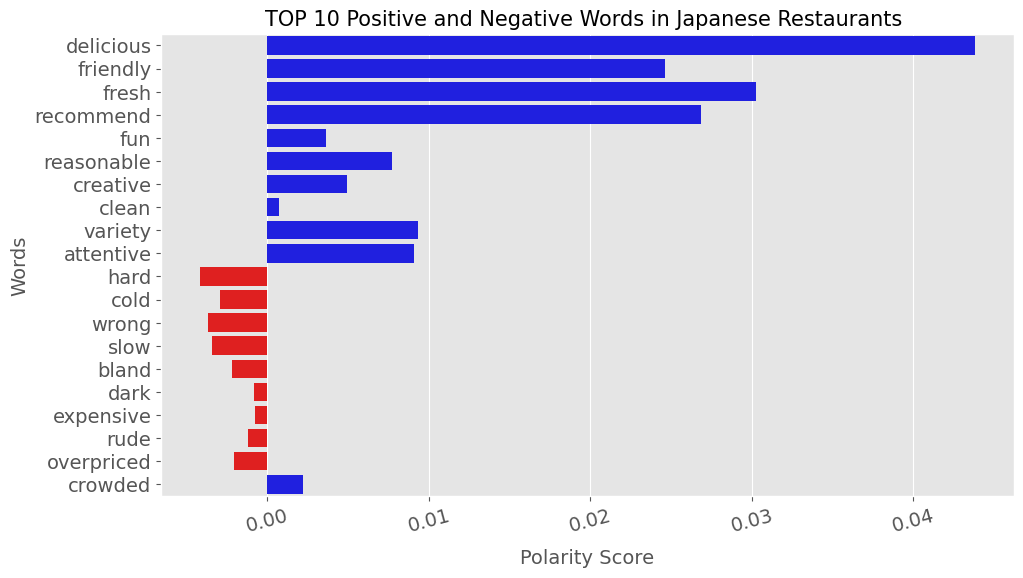

In [97]:
plot_top_words(Japanese_top_words,'Japanese')

**Thai**

In [98]:
Thai_reviews = get_dataset('Thai')
Thai_train = split_data(Thai_reviews, 0.8)
print('Total %d number of reviews' % Thai_train.shape[0])

Total 12420 number of reviews


In [99]:
Thai_polarity_score = get_polarity_score(Thai_train)

In [100]:
get_top_words(Thai_polarity_score,'positive')

,score,frequency,polarity
word,,,
delicious,0.5436,1118,0.0489
friendly,0.2913,1120,0.0263
recommend,0.1776,1016,0.0145
fresh,0.1159,1057,0.0099
tender,0.6749,170,0.0092
authentic,0.1652,579,0.0077
variety,0.5046,185,0.0075
fast,0.2422,355,0.0069
reasonable,0.3194,260,0.0067


In [101]:
get_top_words(Thai_polarity_score,'negative')

,score,frequency,polarity
word,,,
bland,-0.9004,55,-0.0040
hard,-0.1450,301,-0.0035
slow,-0.2896,126,-0.0029
cold,-0.2976,118,-0.0028
fairly,-0.2844,109,-0.0025
poor,-0.8925,30,-0.0022
mediocre,-0.8376,31,-0.0021
fair,-0.2942,88,-0.0021
expensive,-0.3072,83,-0.0021


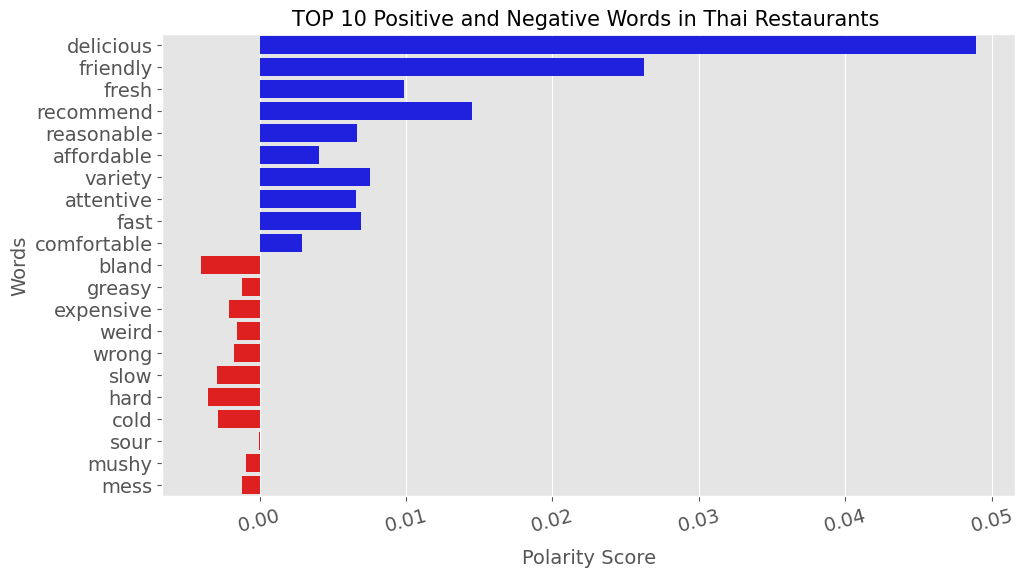

In [102]:
Thai_top_positive_words = ['delicious','friendly','fresh','recommend','reasonable','affordable','variety',
                           'attentive','fast','comfortable']
Thai_top_negative_words = ['bland','greasy','expensive','weird','wrong','slow','hard','cold','sour','mushy','mess']
Thai_top_words = Thai_polarity_score.loc[Thai_top_positive_words+Thai_top_negative_words,'polarity']
plot_top_words(Thai_top_words, 'Thai')

**Chinese**

In [103]:
Chinese_reviews = get_dataset('Chinese')
Chinese_train = split_data(Chinese_reviews, 0.85)
print('Total %d number of reviews' % Chinese_train.shape[0])

Total 15006 number of reviews


In [104]:
Chinese_polarity_score = get_polarity_score(Chinese_train)

In [105]:
get_top_words(Chinese_polarity_score,'positive')

,score,frequency,polarity
word,,,
delicious,0.6677,941,0.0419
friendly,0.4065,1029,0.0279
authentic,0.4657,733,0.0227
fresh,0.2731,1193,0.0217
recommend,0.1986,1017,0.0135
tender,0.5669,236,0.0089
pleasantly,0.8860,148,0.0087
reasonable,0.4215,275,0.0077
fast,0.1916,604,0.0077


In [106]:
get_top_words(Chinese_polarity_score,'negative')

,score,frequency,polarity
word,,,
cold,-0.3461,199,-0.0046
bland,-0.9286,69,-0.0043
sour,-0.0755,741,-0.0037
expensive,-0.3498,120,-0.0028
poor,-0.7332,43,-0.0021
work,-0.1380,215,-0.0020
wrong,-0.1957,149,-0.0019
dirty,-0.7753,37,-0.0019
frozen,-0.5464,49,-0.0018


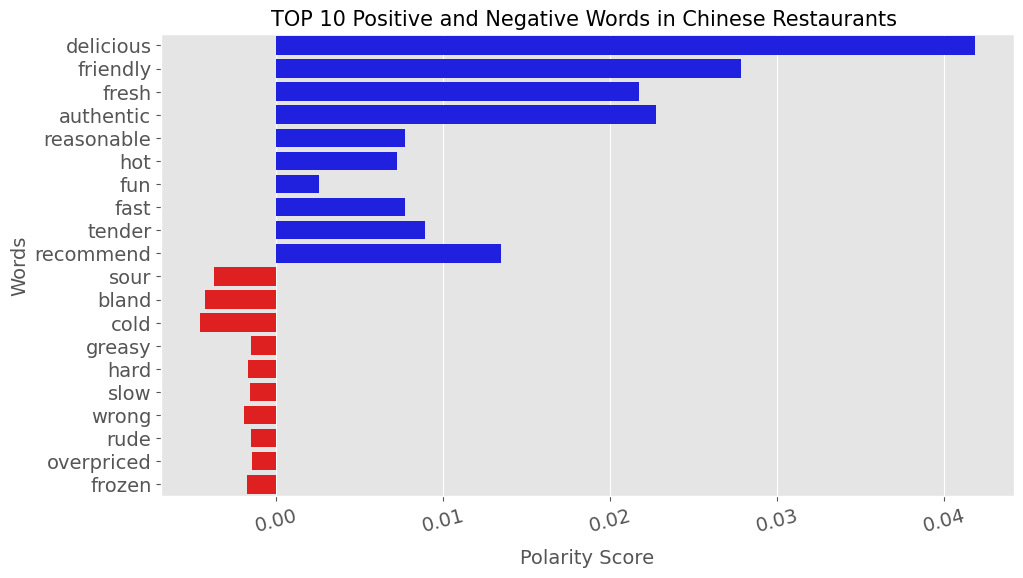

In [107]:
Chinese_top_positive_words = ['delicious','friendly','fresh','authentic','reasonable','hot','fun',
                           'fast','tender','recommend']
Chinese_top_negative_words = ['sour','bland','cold','greasy','hard','slow','wrong','rude','overpriced','frozen']
Chinese_top_words = Chinese_polarity_score.loc[Chinese_top_positive_words+Chinese_top_negative_words,'polarity']
plot_top_words(Chinese_top_words, 'Chinese')

Vietnamese

In [113]:
Vietnamese_reviews = get_dataset('Vietnamese')
Vietnamese_train = split_data(Vietnamese_reviews, 0.7)
print('Total %d number of reviews' % Vietnamese_train.shape[0])

Total 12072 number of reviews


In [114]:
Vietnamese_polarity_score = get_polarity_score(Vietnamese_train)

In [115]:
get_top_words(Vietnamese_polarity_score,'positive')

,score,frequency,polarity
word,,,
delicious,0.5354,1112,0.0493
friendly,0.3183,1096,0.0289
fresh,0.2258,1536,0.0287
clean,0.2239,656,0.0122
tender,0.5675,204,0.0096
fast,0.2506,419,0.0087
liked,0.3250,290,0.0078
attentive,0.3846,235,0.0075
recommend,0.0934,855,0.0066


In [116]:
get_top_words(Vietnamese_polarity_score,'negative')

,score,frequency,polarity
word,,,
hard,-0.2658,296,-0.0065
wrong,-0.3203,134,-0.0036
bland,-1.0144,35,-0.0029
slow,-0.3005,109,-0.0027
lack,-0.4830,66,-0.0026
cold,-0.1495,194,-0.0024
weird,-0.4679,61,-0.0024
poor,-0.9092,30,-0.0023
sad,-0.6119,44,-0.0022


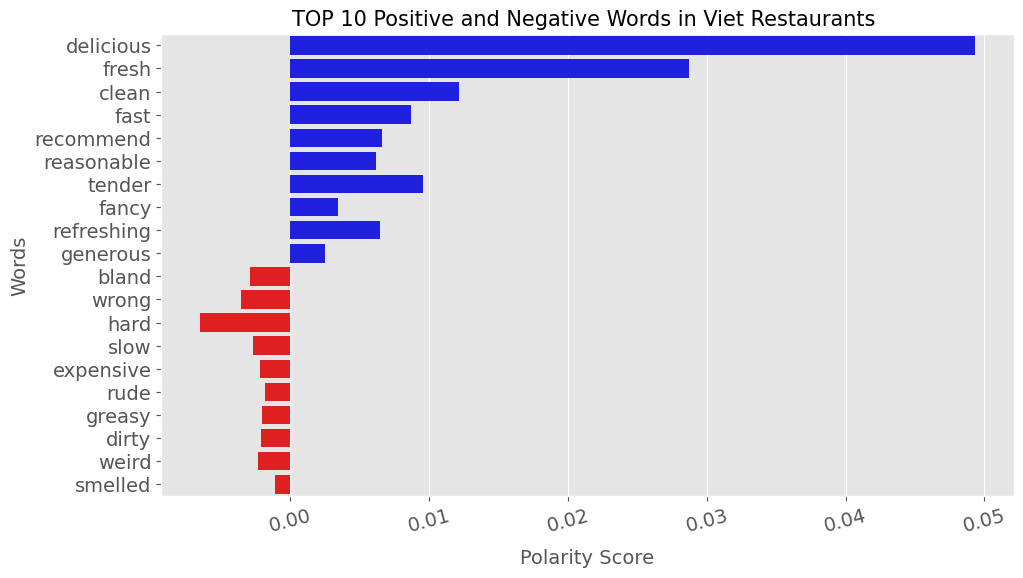

In [117]:
Viet_top_positive_words = ['delicious','fresh','clean','fast','recommend','reasonable','tender',
                           'fancy','refreshing','generous']
Viet_top_negative_words = ['bland','wrong','hard','slow','expensive','rude','greasy','dirty','weird','smelled']
Viet_top_words = Vietnamese_polarity_score.loc[Viet_top_positive_words+Viet_top_negative_words,'polarity']
plot_top_words(Viet_top_words,'Viet')

**French**

In [118]:
French_reviews = get_dataset('French')
French_train = split_data(French_reviews, 0.7)
print('Total %d number of reviews' % French_train.shape[0])

Total 13083 number of reviews


In [119]:
French_polarity_score = get_polarity_score(French_train)

In [120]:
get_top_words(French_polarity_score,'positive')

,score,frequency,polarity
word,,,
delicious,0.4118,1595,0.0502
fresh,0.2296,1322,0.0232
sweet,0.2319,933,0.0165
delicate,1.2894,152,0.0150
tender,0.4547,395,0.0137
beautiful,0.2331,713,0.0127
die,0.4498,355,0.0122
recommend,0.1277,1175,0.0115
enjoy,0.1719,715,0.0094


In [121]:
get_top_words(French_polarity_score, 'negative')

,score,frequency,polarity
word,,,
cold,-0.5335,207,-0.0084
hard,-0.2024,391,-0.0060
slow,-0.2999,152,-0.0035
bland,-0.7873,55,-0.0033
seasoned,-0.2493,167,-0.0032
interesting,-0.2002,191,-0.0029
wrong,-0.1846,207,-0.0029
lost,-0.7435,50,-0.0028
available,-0.2787,123,-0.0026


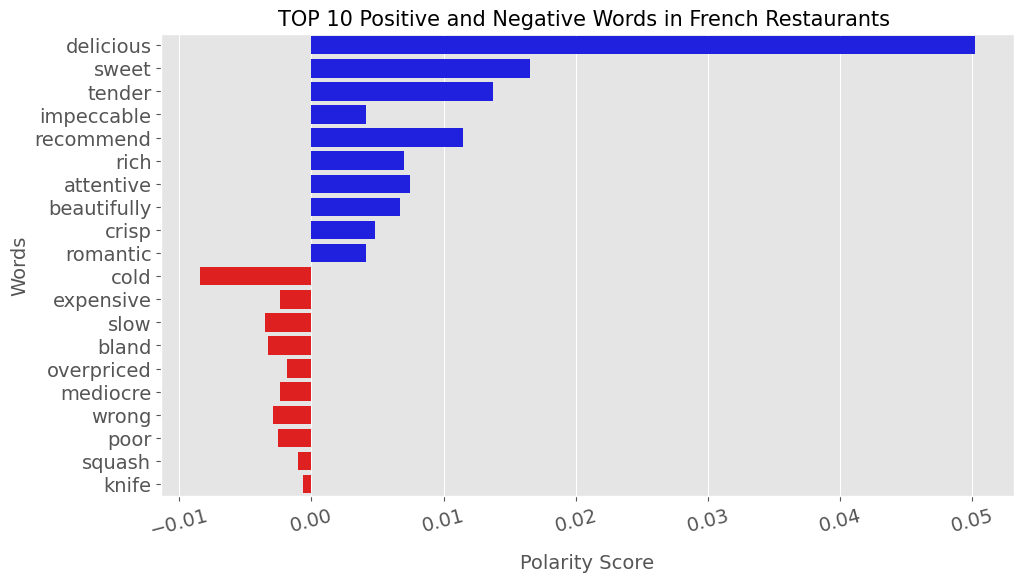

In [122]:
French_top_positive_words = ['delicious','sweet','tender','impeccable','recommend','rich','attentive',
                             'beautifully','crisp','romantic']
French_top_negative_words = ['cold','expensive','slow','bland','overpriced','mediocre','wrong',
                             'poor','squash','knife']
French_top_words = French_polarity_score.loc[French_top_positive_words+French_top_negative_words,'polarity']
plot_top_words(French_top_words,'French')

**Italian**

In [123]:
Italian_reviews = get_dataset('Italian')
Italian_train = split_data(Italian_reviews, 0.9)
print('Total %d number of reviews' % Italian_train.shape[0])

Total 19828 number of reviews


In [124]:
Italian_polarity_score = get_polarity_score(Italian_train)

In [125]:
get_top_words(Italian_polarity_score, 'positive',30)

,score,frequency,polarity
word,,,
delicious,0.5109,1641,0.0423
fresh,0.2674,1807,0.0244
friendly,0.2702,1540,0.0210
die,0.9111,402,0.0185
recommend,0.2413,1473,0.0179
attentive,0.3499,476,0.0084
authentic,0.3471,472,0.0083
pleasantly,1.0315,142,0.0074
variety,0.5250,246,0.0065


In [126]:
get_top_words(Italian_polarity_score, 'negative',30)

,score,frequency,polarity
word,,,
cold,-0.5140,198,-0.0051
wrong,-0.2393,263,-0.0032
hard,-0.1136,479,-0.0027
slow,-0.3380,151,-0.0026
bland,-0.9963,51,-0.0026
poor,-0.8164,62,-0.0026
clearly,-0.6654,72,-0.0024
lost,-0.6696,54,-0.0018
incredibly,-0.2513,139,-0.0018


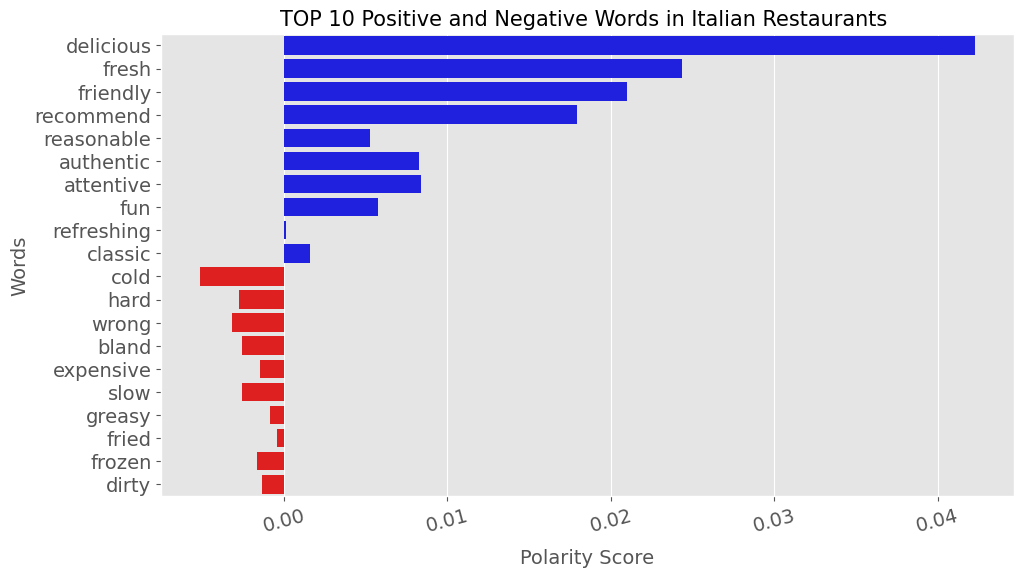

In [127]:
Italian_top_positive_words = ['delicious','fresh','friendly','recommend','reasonable','authentic',
                             'attentive','fun','refreshing','classic']
Italian_top_negative_words = ['cold','hard','wrong','bland','expensive','slow','greasy','fried','frozen','dirty']
Italian_top_words = Italian_polarity_score.loc[Italian_top_positive_words+Italian_top_negative_words,'polarity']
plot_top_words(Italian_top_words,'Italian')

**Combine all top words to compare among different cuisine typies**

In [129]:
all_category = {'cuisine':['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian']}
cuisine_positive_words = pd.DataFrame(all_category)
for i,word in enumerate(Korean_top_positive_words):
    cuisine_positive_words.loc[0,i] = word

In [130]:
for i,word in enumerate(Korean_top_positive_words):
    cuisine_positive_words.iloc[0,i] = word
for i,word in enumerate(Japanese_top_positive_words):
    cuisine_positive_words.iloc[1,i] = word
for i,word in enumerate(Chinese_top_positive_words):
    cuisine_positive_words.iloc[2,i] = word
for i,word in enumerate(Thai_top_positive_words):
    cuisine_positive_words.iloc[3,i] = word
for i,word in enumerate(Viet_top_positive_words):
    cuisine_positive_words.iloc[4,i] = word
for i,word in enumerate(French_top_positive_words):
    cuisine_positive_words.iloc[5,i] = word
for i,word in enumerate(Italian_top_positive_words):
    cuisine_positive_words.iloc[6,i] = word

cuisine_positive_words.drop(9,axis=1,inplace=True)
cuisine_positive_words.columns=['0','1','2','3','4','5','6','7','8','9']
cuisine_positive_words['cuisine']=['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian']
cuisine_positive_words.set_index('cuisine', inplace=True)

In [131]:
all_category = {'cuisine':['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian']}
cuisine_negative_words = pd.DataFrame(all_category)
for i,word in enumerate(Korean_top_negative_words):
    cuisine_negative_words.loc[0,i] = word

In [132]:
for i,word in enumerate(Korean_top_negative_words):
    cuisine_negative_words.iloc[0,i] = word
for i,word in enumerate(Japanese_top_negative_words):
    cuisine_negative_words.iloc[1,i] = word
for i,word in enumerate(Chinese_top_negative_words):
    cuisine_negative_words.iloc[2,i] = word
for i,word in enumerate(Thai_top_negative_words):
    cuisine_negative_words.iloc[3,i] = word
for i,word in enumerate(Viet_top_negative_words):
    cuisine_negative_words.iloc[4,i] = word
for i,word in enumerate(French_top_negative_words):
    cuisine_negative_words.iloc[5,i] = word
for i,word in enumerate(Italian_top_negative_words):
    cuisine_negative_words.iloc[6,i] = word

cuisine_negative_words.drop(9,axis=1,inplace=True)
cuisine_negative_words.columns=['0','1','2','3','4','5','6','7','8','9']
cuisine_negative_words['cuisine']=['Korean','Japanese','Chinese','Thai','Vietnamese','French','Italian']
cuisine_negative_words.set_index('cuisine', inplace=True)

In [133]:
cuisine_positive_words

,0,1,2,3,4,5,6,7,8,9
cuisine,,,,,,,,,,
Korean,delicious,friendly,attentive,recommend,fresh,variety,reasonable,tender,clean,authentic
Japanese,delicious,friendly,fresh,recommend,fun,reasonable,creative,clean,variety,attentive
Chinese,delicious,friendly,fresh,authentic,reasonable,hot,fun,fast,tender,recommend
Thai,delicious,friendly,fresh,recommend,reasonable,affordable,variety,attentive,fast,comfortable
Vietnamese,delicious,fresh,clean,fast,recommend,reasonable,tender,fancy,refreshing,generous
French,delicious,sweet,tender,impeccable,recommend,rich,attentive,beautifully,crisp,romantic
Italian,delicious,fresh,friendly,recommend,reasonable,authentic,attentive,fun,refreshing,classic


In [134]:
cuisine_negative_words

,0,1,2,3,4,5,6,7,8,9
cuisine,,,,,,,,,,
Korean,bland,slow,expensive,overpriced,cold,greasy,sweet,fatty,rude,dirty
Japanese,hard,cold,wrong,slow,bland,dark,expensive,rude,overpriced,crowded
Chinese,sour,bland,cold,greasy,hard,slow,wrong,rude,overpriced,frozen
Thai,bland,greasy,expensive,weird,wrong,slow,hard,cold,sour,mushy
Vietnamese,bland,wrong,hard,slow,expensive,rude,greasy,dirty,weird,smelled
French,cold,expensive,slow,bland,overpriced,mediocre,wrong,poor,squash,knife
Italian,cold,hard,wrong,bland,expensive,slow,greasy,fried,frozen,dirty
